This ipynb assumes the runs for fairdice and the PEDA baselines has been run and saved in /results and /results_baselines

In [2]:
## This part loads in the baselines for PEDA
## Expects the directory structure to be a folder named result_baselines with subfolders for each model
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from pathlib import Path    

def return_location(model='bc', environment='MO-Walker2d-v2', difficulty='amateur',seed='1'):
    if model == 'dt':
        concat_prefs='1'
    else:
        concat_prefs='0'
    base = Path.cwd() 
    pkl_loc = base / "results_baselines" / model / environment / f"{difficulty}_uniform" / "K=20" / \
          "mo_rtg=True" / "rtg_scale=100" / "norm_rew=False" / \
          "concat_state_pref=1" / f"concat_rtg_pref={concat_prefs}" / f"concat_act_pref={concat_prefs}" / \
          "percent=1" / "batch=64" / "dim=512" / "layers=3" / \
          "obj=-1" / "use_pref=False" / "return_loss=False" / \
          "pref_loss=False" / "optim=adam" / f"seed={seed}" / "logs" / "step=5000_rollout.pkl"
    return Path(rf"\\?\{pkl_loc.resolve()}")

file_path = return_location(model='dt', environment='MO-Ant-v2', seed='1')

with open(file_path, 'rb') as f:
    data = pickle.load(f)

rollout_raw_rewards = data['rollout_unweighted_raw_r']
print(rollout_raw_rewards[1][0])
print(rollout_raw_rewards[1][1])

models = ['bc', 'dt', 'rvs']
difficulties = ['expert', 'amateur']
environments = ['MO-Walker2d-v2', 'MO-Ant-v2', 'MO-HalfCheetah-v2', 'MO-Swimmer-v2']
# seeds are 1 to 5

486.5861713886261
2545.178270339966


In [13]:
import os
import glob
import re
import numpy as np
import pandas as pd

def parse_experiment_name(dir_name):
    """Parse experiment directory name to extract metadata"""
    metadata = {}
    beta_match = re.search(r'beta([0-9eE.+-]+)', dir_name)
    if beta_match:
        metadata['beta'] = float(beta_match.group(1))
    
    seed_match = re.search(r'seed(\d+)', dir_name)
    if seed_match:
        metadata['seed'] = int(seed_match.group(1))
    
    if 'expert' in dir_name:
        metadata['quality'] = 'expert'
    elif 'amateur' in dir_name:
        metadata['quality'] = 'amateur'
    
    env_match = re.search(r'MO-(Hopper|Swimmer|HalfCheetah|Walker2d|Ant)-v2', dir_name)
    if env_match:
        metadata['environment'] = f"MO-{env_match.group(1)}-v2"
    
    return metadata

def get_best_beta_from_results(results_dir='./results'):
    """Load all results and compute the best beta per environment/quality"""
    records = []
    
    for exp_dir in glob.glob(os.path.join(results_dir, '*/')):
        eval_dir = os.path.join(exp_dir, 'eval')
        if not os.path.exists(eval_dir):
            continue
        
        dir_name = os.path.basename(os.path.normpath(exp_dir))
        metadata = parse_experiment_name(dir_name)
        if not metadata or 'beta' not in metadata or 'environment' not in metadata:
            continue
        
        raw_file = glob.glob(os.path.join(eval_dir, 'raw_returns_*.npy'))
        norm_file = glob.glob(os.path.join(eval_dir, 'normalized_returns_*.npy'))
        if not raw_file or not norm_file:
            continue
        
        try:
            raw_returns = np.load(raw_file[0])
            norm_returns = np.load(norm_file[0])
        except Exception as e:
            print(f"Failed to load {dir_name}: {e}")
            continue
        
        record = metadata.copy()
        for i in range(raw_returns.shape[1]):
            record[f'reward_{i}_mean'] = np.mean(raw_returns[:, i])
            record[f'reward_{i}_std'] = np.std(raw_returns[:, i])
        
        record['norm_nsw'] = np.mean(np.sum(np.log(norm_returns + 1e-8), axis=1))
        records.append(record)
    
    df = pd.DataFrame(records)
    
    results = []
    for (env, qual), group in df.groupby(['environment', 'quality']):
        best_idx = group['norm_nsw'].idxmax()
        best_row = group.loc[best_idx]
        results.append({
            'environment': env,
            'quality': qual,
            'best_beta': best_row['beta'],
            'mean_r0': best_row['reward_0_mean'],
            'mean_r1': best_row['reward_1_mean']
        })
    
    return pd.DataFrame(results)

def load_all_results(results_dir='./results'):
    """Load all results keeping all beta values for plotting"""
    records = []
    
    for exp_dir in glob.glob(os.path.join(results_dir, '*/')):
        eval_dir = os.path.join(exp_dir, 'eval')
        if not os.path.exists(eval_dir):
            continue
        
        dir_name = os.path.basename(os.path.normpath(exp_dir))
        metadata = parse_experiment_name(dir_name)
        if not metadata or 'beta' not in metadata or 'environment' not in metadata:
            continue
        
        raw_file = glob.glob(os.path.join(eval_dir, 'raw_returns_*.npy'))
        norm_file = glob.glob(os.path.join(eval_dir, 'normalized_returns_*.npy'))
        if not raw_file or not norm_file:
            continue
        
        try:
            raw_returns = np.load(raw_file[0])
            norm_returns = np.load(norm_file[0])
        except Exception as e:
            print(f"Failed to load {dir_name}: {e}")
            continue
        
        record = metadata.copy()
        for i in range(raw_returns.shape[1]):
            record[f'reward_{i}_mean'] = np.mean(raw_returns[:, i])
            record[f'reward_{i}_std'] = np.std(raw_returns[:, i])
        
        record['norm_nsw'] = np.mean(np.sum(np.log(norm_returns + 1e-8), axis=1))
        records.append(record)
    
    df = pd.DataFrame(records)
    return df

# Example usage
all_results = load_all_results('./results')
# Example usage
best_summaries = get_best_beta_from_results('./results')
print(best_summaries)
print(best_summaries['quality'])


         environment  quality  best_beta      mean_r0      mean_r1
0          MO-Ant-v2  amateur    0.01000  1942.261064  1935.240847
1          MO-Ant-v2   expert    0.10000  2122.230064  1847.699928
2  MO-HalfCheetah-v2  amateur    0.10000  1952.789012  2245.438719
3  MO-HalfCheetah-v2   expert    1.00000  1711.946853  2318.469385
4       MO-Hopper-v2  amateur    0.00001  3266.413050  4428.836087
5       MO-Hopper-v2   expert    1.00000  3601.895101  4373.923084
6      MO-Swimmer-v2  amateur    0.00010    55.351469   149.505541
7      MO-Swimmer-v2   expert    0.10000   109.700489   144.825809
8     MO-Walker2d-v2  amateur    0.01000  2174.056304  1582.327069
9     MO-Walker2d-v2   expert    0.00010  1758.031641  2025.680137
0    amateur
1     expert
2    amateur
3     expert
4    amateur
5     expert
6    amateur
7     expert
8    amateur
9     expert
Name: quality, dtype: object


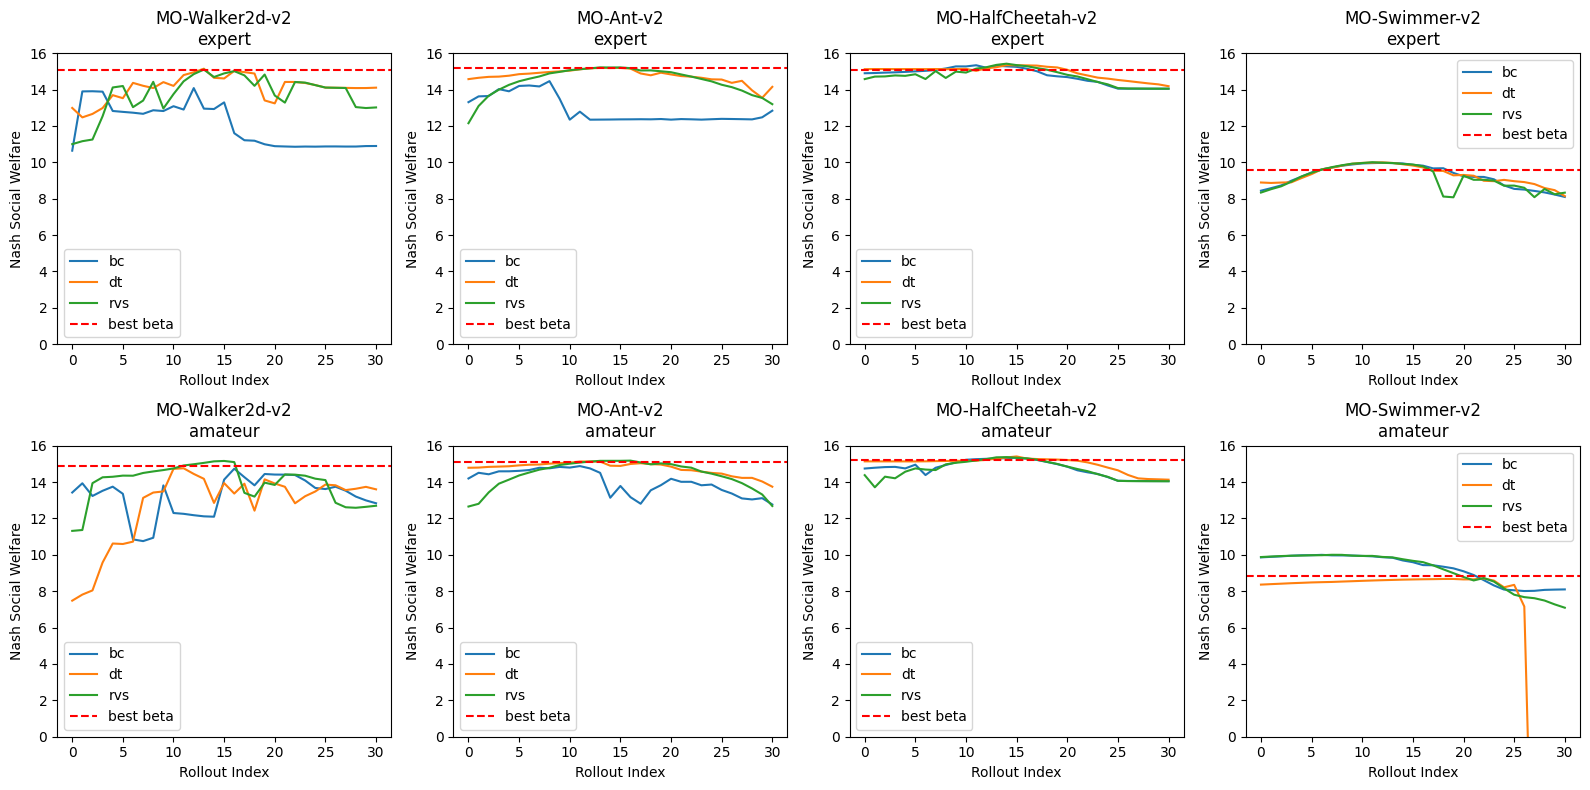

In [5]:
import math
def nash_social_welfare(u1, u2):
    eps = 1e-8
    u1_safe = max(u1 + eps, eps)
    u2_safe = max(u2 + eps, eps)
    return math.log(u1_safe) + math.log(u2_safe)


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for diff_idx, difficulty in enumerate(difficulties):
    for env_idx, environment in enumerate(environments):
        ax = axes[diff_idx, env_idx]
        
        for model in models:
            try:
                file_path = return_location(model=model, environment=environment, 
                                          difficulty=difficulty, seed='1')
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                
                rollout_raw_rewards = data['rollout_unweighted_raw_r']
                nsw_values = [nash_social_welfare(r[0], r[1]) for r in rollout_raw_rewards]
                
                ax.plot(nsw_values[::-1], label=model)
            except Exception as e:
                print(f"Error loading {model}, {environment}, {difficulty}: {e}")
        
        # Add red line for best beta NSW, given that beta we pick the corresponding mean rewards
        best_row = best_summaries[
            (best_summaries['environment'] == environment) & 
            (best_summaries['quality'] == difficulty)
        ]
        
        if not best_row.empty:
            best_nsw = nash_social_welfare(best_row['mean_r0'].values[0], 
                                          best_row['mean_r1'].values[0])
            ax.axhline(y=best_nsw, color='red', linestyle='--', label='best beta')
        
        ax.set_title(f"{environment}\n{difficulty}")
        ax.set_xlabel("Rollout Index")
        ax.set_ylabel("Nash Social Welfare")

        ax.set_ylim(0, 16)
        ax.legend()

plt.tight_layout()
plt.show()


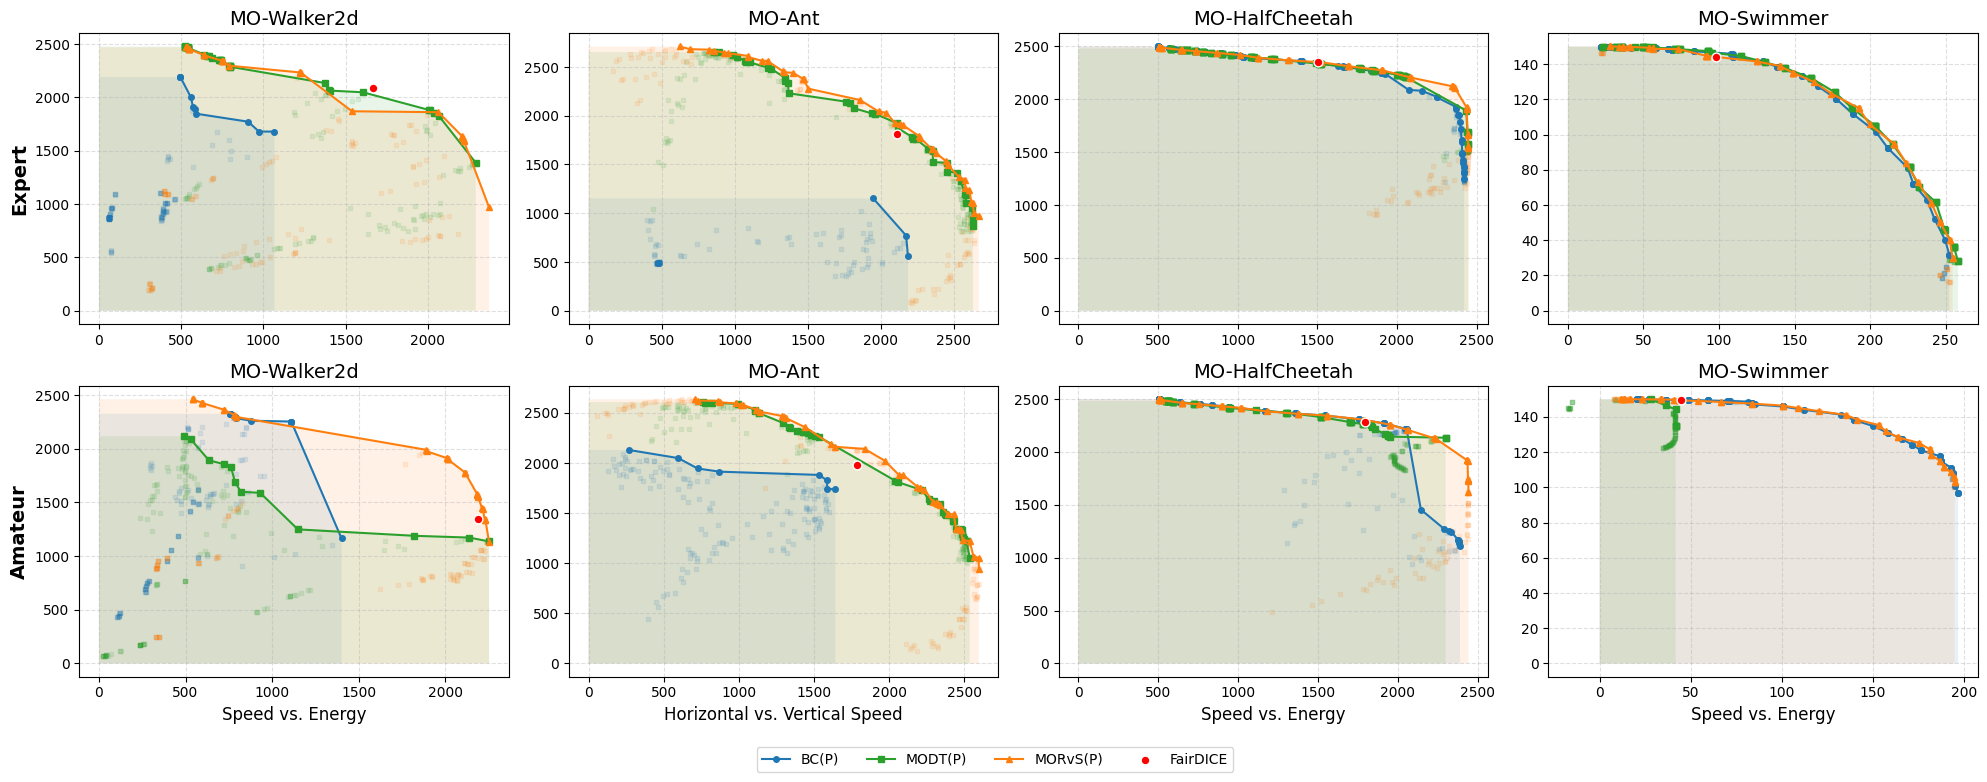

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
from matplotlib.patches import Polygon

# --- HELPER FUNCTIONS ---

def return_location(model='bc', environment='MO-Walker2d-v2', difficulty='amateur', seed='1'):
    # Logic to locate the specific .pkl files based on model parameters
    if model == 'dt':
        concat_prefs = '1'
    else:
        concat_prefs = '0'
    base = Path.cwd() 
    pkl_loc = base / "results_baselines" / model / environment / f"{difficulty}_uniform" / "K=20" / \
          "mo_rtg=True" / "rtg_scale=100" / "norm_rew=False" / \
          "concat_state_pref=1" / f"concat_rtg_pref={concat_prefs}" / f"concat_act_pref={concat_prefs}" / \
          "percent=1" / "batch=64" / "dim=512" / "layers=3" / \
          "obj=-1" / "use_pref=False" / "return_loss=False" / \
          "pref_loss=False" / "optim=adam" / f"seed={seed}" / "logs" / "step=5000_rollout.pkl"
    return Path(rf"\\?\{pkl_loc.resolve()}")

def get_best_beta_summary(csv_path="plots/summary_statistics.csv"):
    # Reads the summary CSV and identifies the best beta for FairDICE performance
    csv_path = Path(csv_path)
    if not csv_path.exists():
        return pd.DataFrame(columns=['environment', 'quality', 'best_beta', 'mean_r0', 'mean_r1'])
    
    df = pd.read_csv(csv_path, header=[0,1,2], index_col=[0,1,2])
    df = df.reset_index()
    df = df.rename(columns={'level_0': 'environment', 'level_1': 'quality', 'level_2': 'beta'})
    
    # Locate specific metric columns for reward 0 and reward 1
    reward_0_col = [col for col in df.columns if 'reward_0_mean' in str(col)][0]
    reward_1_col = [col for col in df.columns if 'reward_1_mean' in str(col)][0]
    nsw_col = [col for col in df.columns if 'norm_nsw' in str(col) and 'mean' in str(col)][0]
    
    results = []
    for (env, qual), group in df.groupby(['environment', 'quality']):
        best_idx = group[nsw_col].idxmax()
        row = group.loc[best_idx]
        results.append({
            'environment': env, 'quality': qual, 
            'mean_r0': row[reward_0_col], 'mean_r1': row[reward_1_col]
        })
    return pd.DataFrame(results)
def compute_pareto_front(points):
    """
    Computes Pareto front for maximization in all dimensions.
    Returns points sorted by first objective.
    """
    points = np.asarray(points)
    n = points.shape[0]
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not is_pareto[i]:
            continue
        # A point is dominated if another point is >= in all dims
        # and > in at least one dim
        dominates = np.all(points >= points[i], axis=1) & np.any(points > points[i], axis=1)
        dominates[i] = False
        if np.any(dominates):
            is_pareto[i] = False

    pf = points[is_pareto]
    return pf[np.argsort(pf[:, 0])]
def shade_staircase(ax, pf, color, alpha=0.1):
    """Creates the rectangular/staircase shaded region, clipped to not exceed the Pareto line."""
    if len(pf) == 0: return
    verts = [(0, 0)]
    verts.append((0, pf[0, 1]))
    
    for i in range(len(pf) - 1):
        verts.append((pf[i, 0], pf[i, 1]))
        verts.append((pf[i+1, 0], pf[i, 1]))
    
    verts.append((pf[-1, 0], pf[-1, 1]))
    verts.append((pf[-1, 0], 0))
    clipped_verts = [(0, 0)]
    clipped_verts.append((0, pf[0, 1]))

    for i in range(len(pf)):
        clipped_verts.append((pf[i, 0], pf[i, 1]))

    clipped_verts.append((pf[-1, 0], 0))
    clipped_verts.append((0, 0))
    
    poly = Polygon(clipped_verts, facecolor=color, alpha=alpha, edgecolor='none', hatch='///', zorder=1)
    ax.add_patch(poly)

# --- PLOTTING SETUP ---

envs = ['MO-Walker2d-v2', 'MO-Ant-v2', 'MO-HalfCheetah-v2', 'MO-Swimmer-v2']
titles = ['MO-Walker2d', 'MO-Ant', 'MO-HalfCheetah', 'MO-Swimmer']
x_labels = ["Speed vs. Energy", "Horizontal vs. Vertical Speed", "Speed vs. Energy", "Speed vs. Energy"]
models = ['bc', 'dt', 'rvs']
m_labels = {'bc': 'BC(P)', 'dt': 'MODT(P)', 'rvs': 'MORvS(P)'}
m_colors = {'bc': '#1f77b4', 'dt': '#2ca02c', 'rvs': '#ff7f0e'}
m_markers = {'bc': 'o', 'dt': 's', 'rvs': '^'}
quals = ['expert', 'amateur']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
best_fairdice = get_best_beta_summary()

for r, quality in enumerate(quals):
    for c, env in enumerate(envs):
        ax = axes[r, c]
        
        for model in models:
            pts = []
            for s in ['1', '2', '3', '4', '5']:
                try:
                    with open(return_location(model, env, quality, s), 'rb') as f:
                        data = pickle.load(f)
                    pts.extend([[x[0], x[1]] for x in data['rollout_unweighted_raw_r']])
                except: continue
            
            if pts:
                pts = np.array(pts)
                pf = compute_pareto_front(pts)
                shade_staircase(ax, pf, m_colors[model])
                # Plot background scatter points
                ax.scatter(pts[:,0], pts[:,1], color=m_colors[model], alpha=0.1, s=12, marker='s', zorder=2)
                # Plot Pareto line
                ax.plot(pf[:,0], pf[:,1], color=m_colors[model], marker=m_markers[model], 
                        markersize=4, linewidth=1.5, label=m_labels[model], zorder=4)

        # Plot FairDICE point
        fd = best_fairdice[(best_fairdice['environment'] == env) & (best_fairdice['quality'] == quality)]
        if not fd.empty:
            ax.scatter(fd['mean_r0'].values[0], fd['mean_r1'].values[0], color='red', 
                       edgecolor='white', s=40, label='FairDICE', zorder=10)

        # Labels and Style
        ax.set_title(titles[c], fontsize=14)
        if c == 0: 
            ax.set_ylabel(quality.capitalize(), fontsize=14, fontweight='bold')
        if r == 1: 
            ax.set_xlabel(x_labels[c], fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.4)

# Global Legend
handles, labels = axes[0,1].get_legend_handles_labels()
dict_labels = dict(zip(labels, handles))
fig.legend(dict_labels.values(), dict_labels.keys(), loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02), frameon=True)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

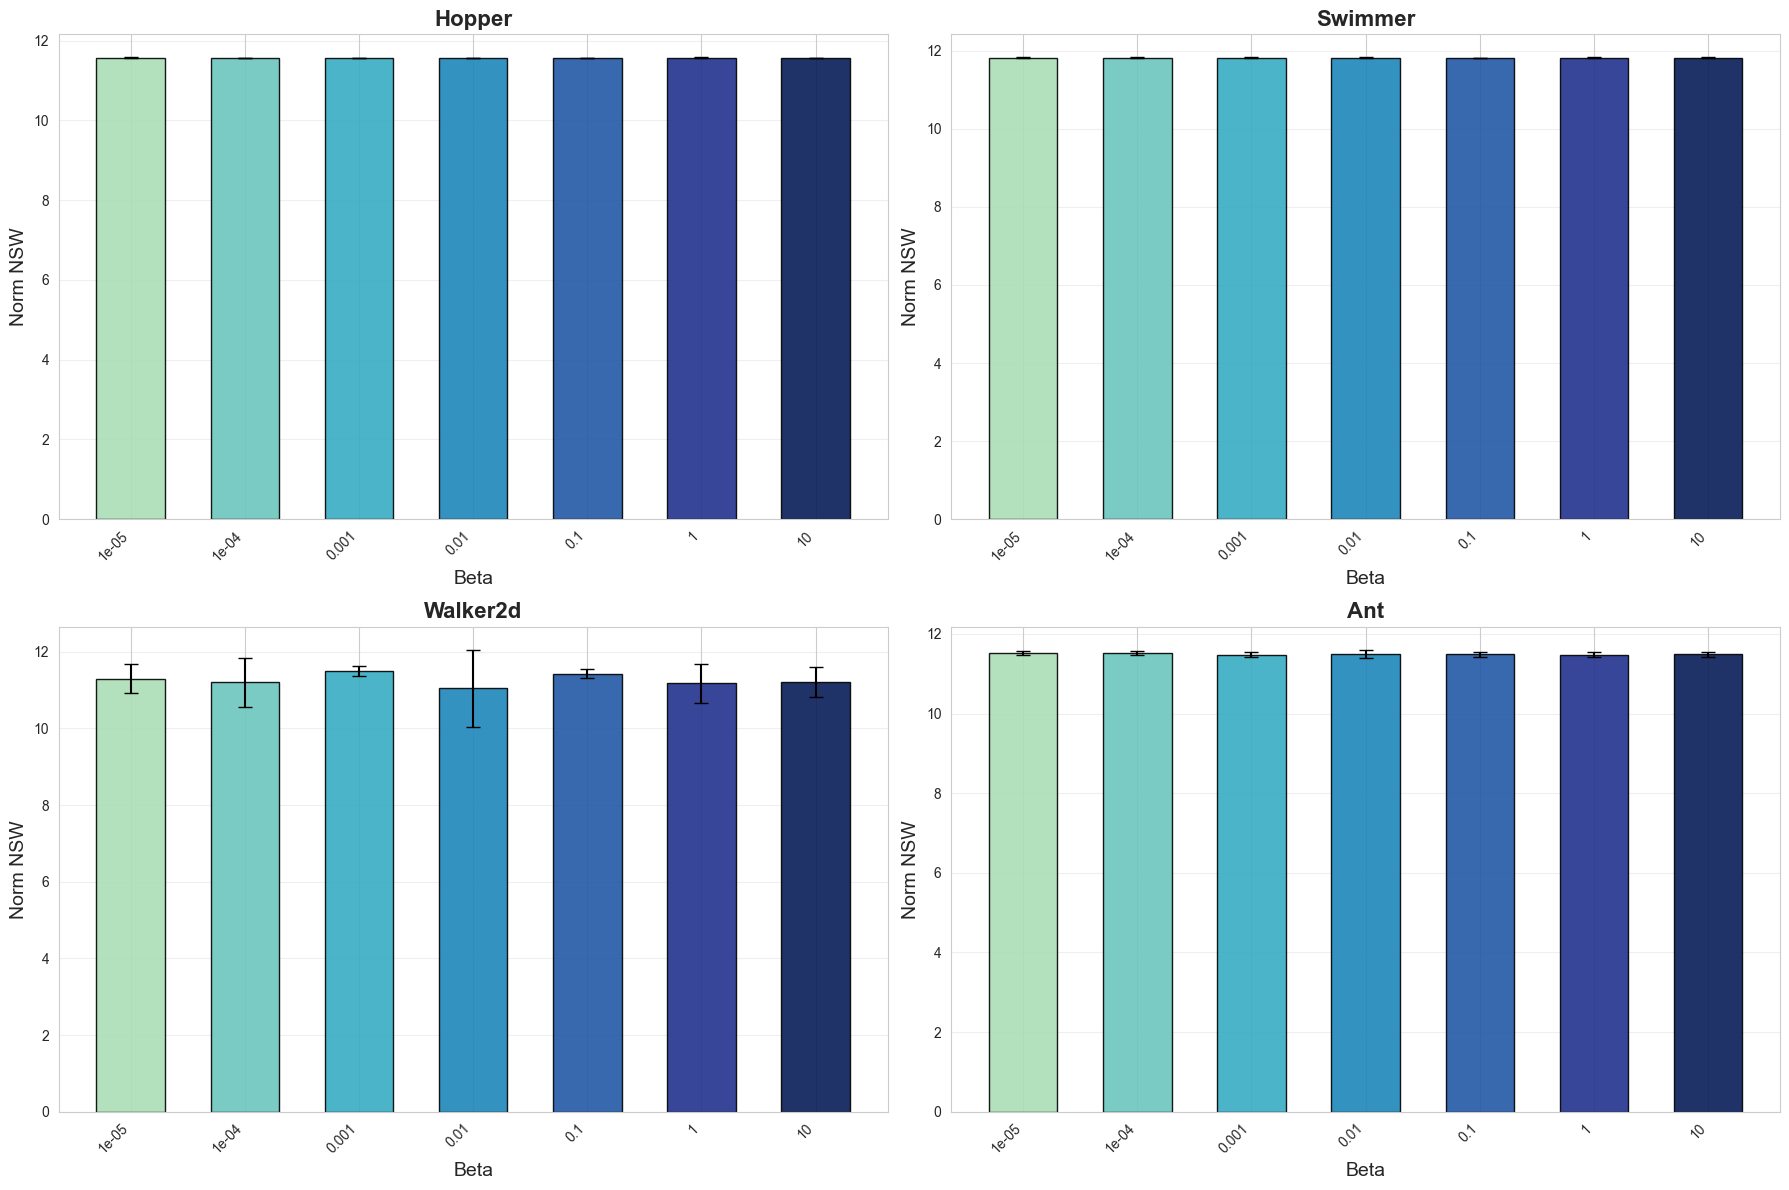

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

def plot_beta_bar_charts_amateur(df, save_path='./plots/beta_bar_charts_amateur.png'):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Define the 4 environments and panel order
    env_order = ['MO-Hopper-v2', 'MO-Swimmer-v2', 'MO-Walker2d-v2', 'MO-Ant-v2']
    env_titles = ['Hopper', 'Swimmer', 'Walker2d', 'Ant']

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    def format_beta(b):
        return f"{b:.0e}" if b < 1e-3 else f"{b:g}"

    cmap = plt.get_cmap('YlGnBu')

    for i, env in enumerate(env_order):
        ax = axes[i]
        env_df = df[(df['environment'] == env) & (df['quality'] == 'amateur')]
        if len(env_df) == 0:
            continue

        betas = sorted(env_df['beta'].unique())
        means = [env_df[env_df['beta']==b]['norm_nsw'].mean() for b in betas]
        stds  = [env_df[env_df['beta']==b]['norm_nsw'].std() for b in betas]

        x = np.arange(len(betas))
        colors = cmap(np.linspace(0.3, 1.0, len(betas)))

        ax.bar(x, means, width=0.6, yerr=stds, capsize=5,
               color=colors, edgecolor='black', alpha=0.9)

        ax.set_xticks(x)
        ax.set_xticklabels([format_beta(b) for b in betas], rotation=45, ha='right')
        ax.set_xlabel('Beta', fontsize=14)
        ax.set_ylabel('Norm NSW', fontsize=14)
        ax.set_title(env_titles[i], fontsize=16, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

all_results = load_all_results('./results')
plot_beta_bar_charts_amateur(all_results)


In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd

BASE_DIR = "./extensions"
EXTS = ["rew1_high", "rew1_low"]
RESULTS_DIR = "./results"
TARGET_BETA = "0.01"

# --------------------------
# 1️⃣ Load the original extensions
# --------------------------
def parse_dir_name(name):
    meta = {}
    if "expert" in name:
        meta["quality"] = "expert"
    elif "amateur" in name:
        meta["quality"] = "amateur"
    else:
        return None
    
    env_match = re.search(r"MO-(Hopper|Swimmer|HalfCheetah|Walker2d|Ant)-v2", name)
    if env_match:
        meta["environment"] = f"MO-{env_match.group(1)}-v2"
    else:
        return None
    
    # Optional: parse seed
    seed_match = re.search(r"_seed(\d+)", name)
    meta["seed"] = int(seed_match.group(1)) if seed_match else None
    return meta

def load_nsw(ext_name, base_dir=BASE_DIR):
    rows = []
    ext_dir = os.path.join(base_dir, ext_name)
    exp_dirs = [d for d in glob.glob(os.path.join(ext_dir, "*/")) if os.path.isdir(d)]
    
    for exp in exp_dirs:
        name = os.path.basename(os.path.normpath(exp))
        meta = parse_dir_name(name)
        if meta is None:
            continue
        
        eval_dir = os.path.join(exp, "eval")
        norm_files = glob.glob(os.path.join(eval_dir, "normalized_returns_*.npy"))
        if not norm_files:
            continue
        
        norm_returns = np.load(norm_files[0])
        nsw = np.mean(np.sum(np.log(norm_returns + 1e-8), axis=1))
        
        rows.append({
            "environment": meta["environment"],
            "quality": meta["quality"],
            "extension": ext_name,
            "nsw": nsw
        })
    
    return pd.DataFrame(rows)

df_exts = pd.concat([load_nsw(ext) for ext in EXTS], ignore_index=True)

# --------------------------
# 2️⃣ Load the beta=0.01 results as "Non-filtered"
# --------------------------
def parse_dir_name_beta(name):
    meta = {}
    if "expert" in name:
        meta["quality"] = "expert"
    elif "amateur" in name:
        meta["quality"] = "amateur"
    else:
        return None
    
    env_match = re.search(r"MO-(Hopper|Swimmer|HalfCheetah|Walker2d|Ant)-v2", name)
    if env_match:
        meta["environment"] = f"MO-{env_match.group(1)}-v2"
    else:
        return None
    
    # beta filter
    beta_match = re.search(r"_beta([0-9.]+)", name)
    if not beta_match or beta_match.group(1) != TARGET_BETA:
        return None
    
    # seed
    seed_match = re.search(r"_seed(\d+)", name)
    meta["seed"] = int(seed_match.group(1)) if seed_match else None
    
    return meta

rows = []
for exp in glob.glob(os.path.join(RESULTS_DIR, "*/")):
    name = os.path.basename(os.path.normpath(exp))
    meta = parse_dir_name_beta(name)
    if meta is None:
        continue
    
    eval_dir = os.path.join(exp, "eval")
    norm_files = glob.glob(os.path.join(eval_dir, "normalized_returns_*.npy"))
    if not norm_files:
        continue
    
    norm_returns = np.load(norm_files[0])
    nsw = np.mean(np.sum(np.log(norm_returns + 1e-8), axis=1))
    
    rows.append({
        "environment": meta["environment"],
        "quality": meta["quality"],
        "extension": "Non-filtered",
        "nsw": nsw
    })

df_beta = pd.DataFrame(rows)

# --------------------------
# 3️⃣ Combine both
# --------------------------
df_all = pd.concat([df_exts, df_beta], ignore_index=True)

summary = (
    df_all.groupby(["environment", "quality", "extension"])
          .agg(mean_nsw=("nsw", "mean"),
               std_nsw=("nsw", "std"))
          .reset_index()
)

# Format mean ± std
summary["mean_std"] = summary.apply(
    lambda r: f"{r.mean_nsw:.4f} ± {r.std_nsw:.4f}",
    axis=1
)

# Pivot table: environment × quality × extension
table = summary.pivot_table(
    index=["environment", "quality"],
    columns="extension",
    values="mean_std",
    aggfunc="first"
)

print("\nNSW comparison (Non-filtered + rew1_high vs rew1_low)\n")
display(table)



NSW comparison (Non-filtered + rew1_high vs rew1_low)



extension                      Non-filtered         rew1_high  \
environment       quality                                       
MO-Ant-v2         amateur  11.4912 ± 0.1058  11.5239 ± 0.0063   
                  expert   11.4510 ± 0.0858  11.4920 ± 0.0104   
MO-HalfCheetah-v2 amateur  11.8161 ± 0.1321  12.1125 ± 0.0055   
                  expert   11.8146 ± 0.0165  12.0610 ± 0.0659   
MO-Hopper-v2      amateur  11.5671 ± 0.0064  11.4053 ± 0.1039   
                  expert   11.2343 ± 0.0781               NaN   
MO-Swimmer-v2     amateur  11.8200 ± 0.0035  11.7690 ± 0.0040   
                  expert   11.6056 ± 0.1044  11.6020 ± 0.0263   
MO-Walker2d-v2    amateur  11.0414 ± 1.0042  11.5927 ± 0.0284   
                  expert   11.4328 ± 0.2697  11.3765 ± 0.2139   

extension                          rew1_low  
environment       quality                    
MO-Ant-v2         amateur  11.5589 ± 0.0124  
                  expert   11.4757 ± 0.0167  
MO-HalfCheetah-v2 amateur  11.4863 ± 0.0064  
                  expert   11.2543 ± 0.0151  
MO-Hopper-v2      amateur  11.5983 ± 0.0040  
                  expert                NaN  
MO-Swimmer-v2     amateur  11.8088 ± 0.0006  
                  expert   11.5608 ± 0.0322  
MO-Walker2d-v2    amateur  11.3435 ± 0.1877  
                  expert   11.0103 ± 0.1634